In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf


from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [6]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### RF params
responsive_test = None
responsive_thr = None
n_stds = None
response_type = 'dff'

#### Filter RF datasets by
do_spherical_correction=False
rf_filter_by=None
rf_fit_thr=0.5
rf_type = 'sphr' if do_spherical_correction else ''
rf_fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
rf_str = '%s_%s' % (rf_filter_by, rf_type)
print(rf_str)
print(rf_fit_desc)

#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.002
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
retino_str = '%s-thr%.3f' % (pass_criterion, mag_thr)
print(retino_str)


None_
fit-2dgaus_dff-no-cutoff
pixels-thr0.002


In [10]:
# Set data identifiers
fig_id = '%s|%s|%s -- ret: %s| rf: %s, filter %s' % (fov_type, state, traceid, retino_str, rf_fit_desc, rf_str)
print(fig_id)


zoom2p0x|awake|traces001 -- ret: pixels-thr0.002| rf: fit-2dgaus_dff-no-cutoff, filter None_


# Output dir

In [11]:
basedir = os.path.join(aggr_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc), 'compare_retino')

if not os.path.exists(basedir):
    os.makedirs(basedir)
basedir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/compare_retino'

# Metadata

In [27]:
sdata = aggr.get_aggregate_info(traceid=traceid)
rdata = sdata[sdata['experiment'].isin(['retino', 'rfs', 'rfs10'])]
edata = aggr.include_dsets_with(rdata, experiment='retino', also_include='rfs')
both_datakeys = edata['datakey'].unique()
print(len(both_datakeys))

Segmentation: missing 9 dsets


In [26]:
print(rdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(edata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                26
Ll                 4
Lm                23
V1                19
             datakey
visual_area         
Li                16
Ll                 2
Lm                17
V1                19


In [25]:
missing_rfs = sdata[(sdata['experiment']=='retino') & ~(sdata['datakey'].isin(both_datakeys))]['datakey'].unique()
print(len(missing_rfs))

14


# Load RF fits

In [132]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

In [268]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [136]:
print("Loading RF fits (%s)" % rf_fit_desc)
rfdf = rfutils.load_rfdf_with_positions(rf_fit_desc, traceid='traces001', filter_by=None, reliable_only=True)

Loading RF fits (fit-2dgaus_dff-no-cutoff)
Loading existing RF coord conversions...


In [269]:
rfdf.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'fx', u'fy', u'ratio_xy', u'theta_c', u'theta_Mm_deg', u'major_axis',
       u'minor_axis', u'anisotropy', u'theta_Mm_c', u'aniso_index',
       u'fov_xpos', u'fov_xpos_pix', u'fov_ypos', u'fov_ypos_pix', u'ml_pos',
       u'ap_pos'],
      dtype='object')

In [270]:
rfdf_avg = aggr.get_rfdata(rfdf, rfdf, average_repeats=True)

In [140]:
from pipeline.python.retinotopy import utils as retutils
import matplotlib.gridspec as gridspec

In [508]:
def filter_retino_cells(magratios, pass_criterion='all', mag_thr=0.01):
    conds = [c for c in magratios.columns if c!='blank']
    if pass_criterion=='all':
        soma_rois = [i for i in magratios.index \
                        if all(magratios[conds].loc[i] >= mag_thr)]
    elif pass_criterion=='mean':
        meanrs = magratios[conds].mean(axis=1)
        soma_rois = meanrs[meanrs>mag_thr].index.tolist()
        
    elif pass_criterion=='either':
        az_conds = [c for c in magratios.columns if c in ['right', 'left']]
        el_conds = [c for c in magratios.columns if c in ['top', 'bottom']]
        soma_rois = [i for i in magratios.index \
                    if (any(magratios[az_conds].loc[i] >= mag_thr) \
                        and (any(magratios[el_conds].loc[i] >= mag_thr))) ]

    elif pass_criterion == 'any':
        soma_rois = [i for i in magratios.index \
                        if any(magratios[conds].loc[i] >= mag_thr) ]
    return soma_rois

In [558]:
reload(retutils)

<module 'pipeline.python.retinotopy.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py'>

In [556]:
# datakey = '20190602_JC091_fov1'
# visual_area='Li'

datakey = '20190622_JC085_fov1'
visual_area='V1'
currdf = rfdf_avg[(rfdf_avg['visual_area']==visual_area) & (rfdf_avg['datakey']==datakey)]
currdf.shape

(118, 34)

In [557]:

session, animalid, fovnum = putils.split_datakey_str(datakey)
fov='FOV%i_zoom2p0x' % fovnum
retinorun='retino_run1'

fft_results = retutils.load_fft_results(animalid, session, fov, retinorun=retinorun, 
                    traceid=traceid, rootdir=rootdir, create_new=True, trace_type='raw',
                    detrend_after_average=True)

# fft_results['fft_soma']
magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_results['fft_soma']) # return -pi, pi
phases_w = retutils.correct_phase_wrap(phases_soma) # wraps from 0 to 2pi

... loading paradigm info
Found 16 tifs
Temporal ds: 5.00
... loading traces (neuropil)
... loading traces (raw)
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw
raw


In [559]:
# Get absolute coords
phases_w = retutils.correct_phase_wrap(phases_soma) # wraps from 0 to 2pi
absolute_az = (phases_w['left'] - phases_w['right']) / 2.  # cont (-pi, pi)
absolute_el = absolute_el = (phases_w['bottom'] - phases_w['top']) / 2.
print(absolute_az.min(), absolute_az.max())

(-2.8549929327357453, 2.774038373842301)


<IPython.core.display.Javascript object>


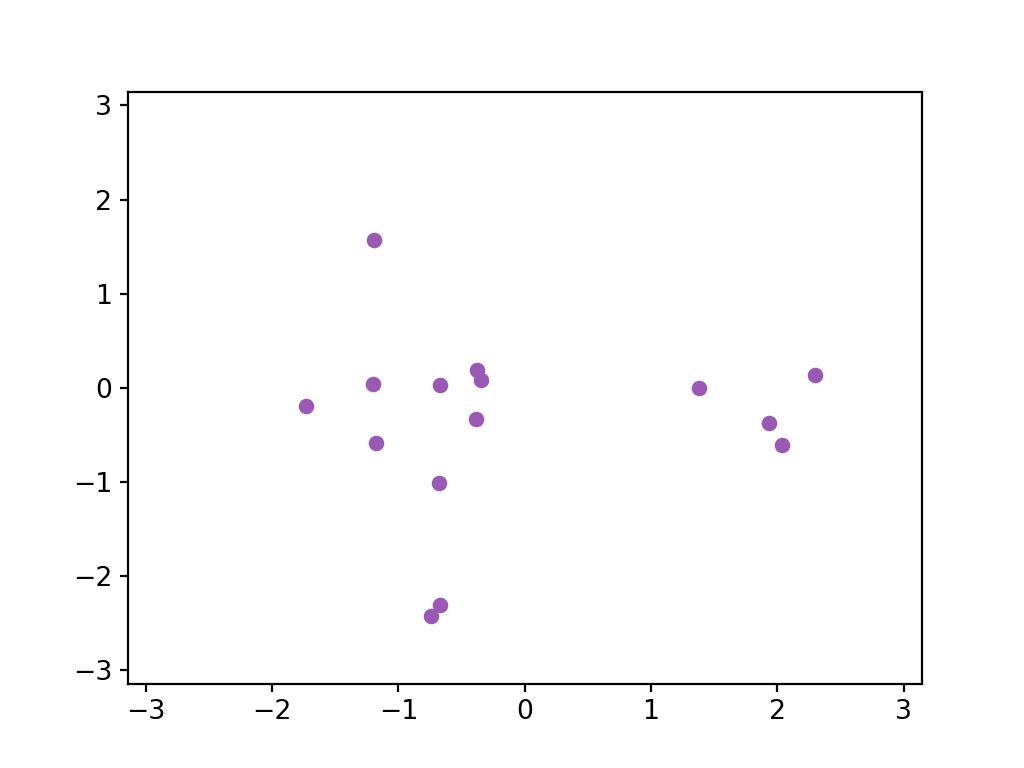

In [560]:
fig, ax= pl.subplots()

ax.set_ylim([-np.pi, np.pi])
ax.set_xlim([-np.pi, np.pi])

ax.scatter(absolute_az.loc[incl_rois], absolute_el.loc[incl_rois])


In [580]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

screen_top = screen['altitude_deg']/2.
screen_right = screen['azimuth_deg']/2.
elev_cutoff = screen_top / screen_right
print(elev_cutoff)


vmin, vmax = -np.pi, np.pi
lin_az = retutils.convert_range(absolute_az, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
lin_el = retutils.convert_range(absolute_el, oldmin=vmin, oldmax=vmax,newmin=screen_min, newmax=screen_max)
retino_pos = pd.DataFrame({'az': lin_az, 'el': lin_el}).astype(float)


0.563106617463


In [581]:
curr_rois = currdf['cell'].unique()
magratios_soma.loc[curr_rois].shape

retinodf = retino_pos.loc[curr_rois]


In [582]:
retinodf['az'].min(), retinodf['az'].max()

(-47.01800480530318, 45.05252758682323)

In [583]:
retinodf['az'].min(), retinodf['az'].max()

(-47.01800480530318, 45.05252758682323)

8 of 20 cells pass (118 cells in area)


<IPython.core.display.Javascript object>


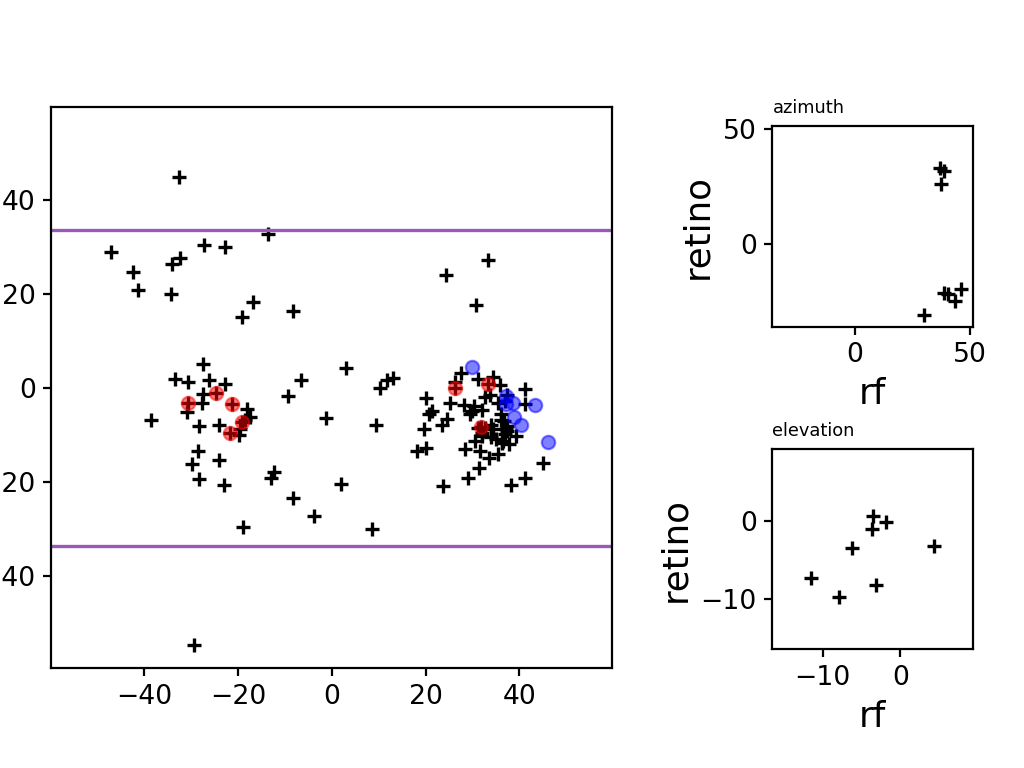

In [585]:
pass_rois = filter_retino_cells(magratios_soma, pass_criterion='mean', mag_thr=0.02)
incl_rois = np.intersect1d(pass_rois, curr_rois)
print("%i of %i cells pass (%i cells in area)" % (len(incl_rois), len(pass_rois), len(curr_rois)))


fig = pl.figure()
gs = gridspec.GridSpec(2,3) #fig.add_gridspec(2,2)

# RETINO.
ax=fig.add_subplot(gs[0:2, 0:-1])
ax.set_xlim([-screen_max, screen_max])
ax.set_ylim([-screen_max, screen_max])
vmin, vmax = screen_min, screen_max
ax.axhline(y=vmin*elev_cutoff)
ax.axhline(y=vmax*elev_cutoff)
ax.set_aspect('equal')
# RETINO:  plot all
ax.scatter(retinodf['az'], retinodf['el'], c='k', marker='+', label='all')

# RETINO:  plot well-fit
ax.scatter(retinodf.loc[incl_rois]['az'], retinodf.loc[incl_rois]['el'], c='r', marker='o', alpha=0.5)

# RFS:  plot positions
rf_x = currdf[currdf['cell'].isin(incl_rois)]['x0'].copy()
rf_y = currdf[currdf['cell'].isin(incl_rois)]['y0'].copy()
ax.scatter(rf_x, rf_y, c='b', alpha=0.5)


# compare ----------------
retino_x = np.array([x.loc[i] if i in x.index else np.nan for i in incl_rois])
retino_y = np.array([y.loc[i] if i in y.index else np.nan for i in incl_rois])

# X-POSITION 
ax=fig.add_subplot(gs[0, -1])
min_x = min([rf_x.min(), retino_x.min()])
max_x = max([rf_x.max(), retino_x.max()])
ax.set_title('azimuth', fontsize=8, loc='left')

ax.scatter(rf_x, retino_x, c='k', marker='+')
ax.set_ylim([min_x-5, max_x+5])
ax.set_xlim([min_x-5, max_x+5])
ax.set_aspect('equal')

ax.set_xlabel('rf')
ax.set_ylabel('retino')

# Y-POSITION
ax=fig.add_subplot(gs[1, -1])
min_y = min([rf_y.min(), retino_y.min()])
max_y = max([rf_y.max(), retino_y.max()])
ax.set_title('elevation', fontsize=8, loc='left')

ax.scatter(rf_y, retino_y, c='k', marker='+')
ax.set_ylim([min_y-5, max_y+5])
ax.set_xlim([min_y-5, max_y+5])
ax.set_aspect('equal')
ax.set_xlabel('rf')
ax.set_ylabel('retino')

pl.subplots_adjust(wspace=0.8, right=0.95, left=0.05)

In [603]:
#20190522_JC084_fov1: currdf[currdf['cell'].isin([178, 236, 237])][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]


funky = retinodf[retinodf['az']<0].loc[incl_rois].dropna().index.tolist() 

currdf[currdf['cell'].isin(funky)][['cell', 'x0', 'y0', 'std_x', 'std_y', 'r2']]

,cell,x0,y0,std_x,std_y,r2
2026,57,40.245319,-7.887900,8.696274,8.329861,0.826643
2028,60,30.006214,4.357394,6.108179,4.285282,0.648895
2039,87,43.389460,-3.654796,11.122051,20.473931,0.797573
2052,154,46.191499,-11.498976,11.463304,7.200042,0.655070
2060,175,38.786798,-6.191034,12.087727,10.345811,0.673327


In [605]:
retinodf.loc[funky]

,az,el
57,-21.696288,-9.721331
60,-30.692230,-3.174005
87,-24.632229,-1.038595
154,-19.207769,-7.302990
175,-21.277743,-3.474901


In [592]:
soma_traces = retutils.load_traces(animalid, session, fov, run=retinorun,
                        analysisid='traces001', trace_type='raw', detrend_after_average=True)

... loading traces (raw)
Specified ID <traces001> not eligible. Selecting 1st of [u'analysis002']


<IPython.core.display.Javascript object>


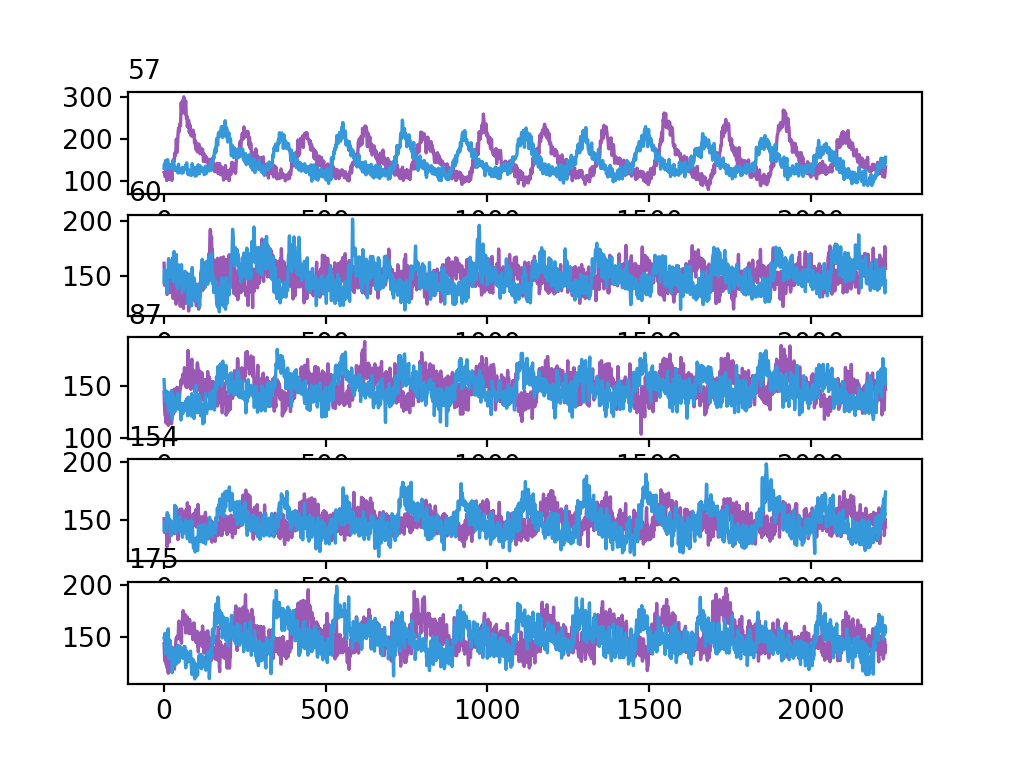

In [602]:

fig, axn = pl.subplots(len(funky), 1)

retino_conds = soma_traces.keys()

for ax, rid in zip(axn.flat, funky):
    for cond in retino_conds:
        if cond in ['right', 'left']:
            
            ax.plot(soma_traces[cond][rid], label=cond)
    ax.set_title(rid, loc='left')

<IPython.core.display.Javascript object>


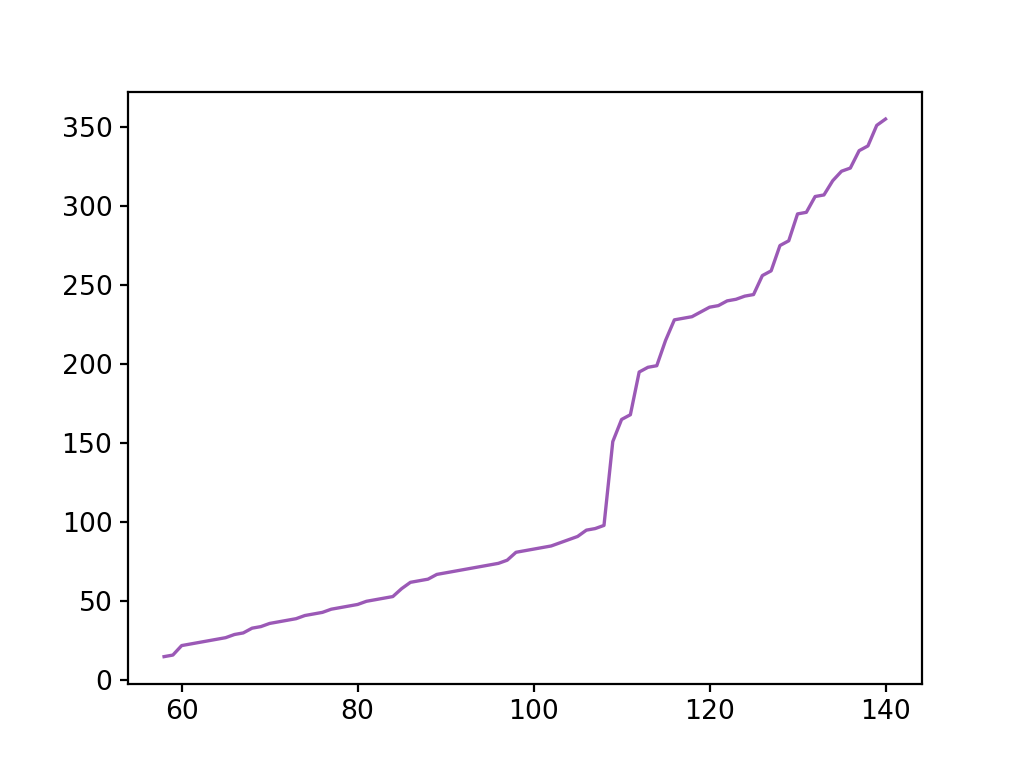

In [312]:
pl.figure()
pl.plot(currdf['cell'])


In [314]:
np.diff(sorted(currdf['cell']))



array([ 1,  6,  1,  1,  1,  1,  1,  2,  1,  3,  1,  2,  1,  1,  1,  2,  1,
        1,  2,  1,  1,  1,  2,  1,  1,  1,  5,  4,  1,  1,  3,  1,  1,  1,
        1,  1,  1,  1,  2,  5,  1,  1,  1,  1,  2,  2,  2,  4,  1,  2, 53,
       14,  3, 27,  3,  1, 16, 13,  1,  1,  3,  3,  1,  3,  1,  2,  1, 12,
        3, 16,  3, 17,  1, 10,  1,  9,  6,  2, 11,  3, 13,  4])